# Audio Signal Denoising

**Objective:**
Implement a deep learning model to denoise audio signals.

**Dataset:**
* UrbanSound8K: Contains 8732 sound excerpts useful for training denoising algorithms.
* Noisy Speech Database: Created specifically for training speech enhancement algorithms, publicly available.



## Libraries and Packages

In [1]:
import librosa
import numpy as np
import math
import scipy

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import glob
import warnings
import pickle
from sklearn.utils import shuffle

import multiprocessing
import os
import shutil

import pandas as pd

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

## Classes and Functions

In [2]:
def inverse_stft_transform(stft_features, window_length, overlap):
    return librosa.istft(stft_features, win_length=window_length, hop_length=overlap)


def revert_features_to_audio(features, phase, window_length, overlap, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return inverse_stft_transform(features, window_length=window_length, overlap=overlap)


def play(audio, sample_rate):
    # ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file
    IPython.display.Audio(data=audio, rate=sample_rate)
#     sd.play(audio, sample_rate, blocking=True)


def add_noise_to_clean_audio(clean_audio, noise_signal):
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def read_audio(filepath, sample_rate, normalize=True):
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize is True:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
        # audio = librosa.util.normalize(audio)
    return audio, sr


def prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments


def get_input_features(predictorsList):
    predictors = []
    for noisy_stft_mag_features in predictorsList:
        # For CNN, the input feature consisted of 8 consecutive noisy
        # STFT magnitude vectors of size: 129 × 8,
        # TODO: duration: 100ms
        inputFeatures = prepare_input_features(noisy_stft_mag_features)
        # print("inputFeatures.shape", inputFeatures.shape)
        predictors.append(inputFeatures)

    return predictors


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def get_tf_feature(noise_stft_mag_features, clean_stft_magnitude, noise_stft_phase):
    noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
    clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
    noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'noise_stft_phase': _bytes_feature(noise_stft_phase),
        'noise_stft_mag_features': _bytes_feature(noise_stft_mag_features),
        'clean_stft_magnitude': _bytes_feature(clean_stft_magnitude)}))
    return example

In [3]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.windows.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                              n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length,
                                                    hop_length=self.overlap,
                                                    win_length=self.window_length, window=self.window,
                                                    center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [4]:
class Dataset:
    def __init__(self, clean_filenames, noise_filenames, **config):
        self.clean_filenames = clean_filenames
        self.noise_filenames = noise_filenames
        self.sample_rate = config['fs']
        self.overlap = config['overlap']
        self.window_length = config['windowLength']
        self.audio_max_duration = config['audio_max_duration']

    def _sample_noise_filename(self):
        return np.random.choice(self.noise_filenames)

    def _remove_silent_frames(self, audio):
        trimed_audio = []
        indices = librosa.effects.split(audio, hop_length=self.overlap, top_db=20)

        for index in indices:
            trimed_audio.extend(audio[index[0]: index[1]])
        return np.array(trimed_audio)

    def _phase_aware_scaling(self, clean_spectral_magnitude, clean_phase, noise_phase):
        assert clean_phase.shape == noise_phase.shape, "Shapes must match."
        return clean_spectral_magnitude * np.cos(clean_phase - noise_phase)

    def get_noisy_audio(self, *, filename):
        return read_audio(filename, self.sample_rate)

    def _audio_random_crop(self, audio, duration):
        audio_duration_secs = librosa.get_duration(y=audio, sr=self.sample_rate)

        ## duration: length of the cropped audio in seconds
        if duration >= audio_duration_secs:
            # print("Passed duration greater than audio duration of: ", audio_duration_secs)
            return audio

        audio_duration_ms = math.floor(audio_duration_secs * self.sample_rate)
        duration_ms = math.floor(duration * self.sample_rate)
        idx = np.random.randint(0, audio_duration_ms - duration_ms)
        return audio[idx: idx + duration_ms]

    def _add_noise_to_clean_audio(self, clean_audio, noise_signal):
        if len(clean_audio) >= len(noise_signal):
            # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
            while len(clean_audio) >= len(noise_signal):
                noise_signal = np.append(noise_signal, noise_signal)

        ## Extract a noise segment from a random location in the noise file
        ind = np.random.randint(0, noise_signal.size - clean_audio.size)

        noiseSegment = noise_signal[ind: ind + clean_audio.size]

        speech_power = np.sum(clean_audio ** 2)
        noise_power = np.sum(noiseSegment ** 2)
        noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
        return noisyAudio

    def parallel_audio_processing(self, clean_filename):

        clean_audio, _ = read_audio(clean_filename, self.sample_rate)

        # remove silent frame from clean audio
        clean_audio = self._remove_silent_frames(clean_audio)

        noise_filename = self._sample_noise_filename()

        # read the noise filename
        noise_audio, sr = read_audio(noise_filename, self.sample_rate)

        # remove silent frame from noise audio
        noise_audio = self._remove_silent_frames(noise_audio)

        # sample random fixed-sized snippets of audio
        clean_audio = self._audio_random_crop(clean_audio, duration=self.audio_max_duration)

        # add noise to input image
        noiseInput = self._add_noise_to_clean_audio(clean_audio, noise_audio)

        # extract stft features from noisy audio
        noisy_input_fe = FeatureExtractor(noiseInput, windowLength=self.window_length, overlap=self.overlap,
                                          sample_rate=self.sample_rate)
        noise_spectrogram = noisy_input_fe.get_stft_spectrogram()

        # Or get the phase angle (in radians)
        # noisy_stft_magnitude, noisy_stft_phase = librosa.magphase(noisy_stft_features)
        noise_phase = np.angle(noise_spectrogram)

        # get the magnitude of the spectral
        noise_magnitude = np.abs(noise_spectrogram)

        # extract stft features from clean audio
        clean_audio_fe = FeatureExtractor(clean_audio, windowLength=self.window_length, overlap=self.overlap,
                                          sample_rate=self.sample_rate)
        clean_spectrogram = clean_audio_fe.get_stft_spectrogram()
        # clean_spectrogram = cleanAudioFE.get_mel_spectrogram()

        # get the clean phase
        clean_phase = np.angle(clean_spectrogram)

        # get the clean spectral magnitude
        clean_magnitude = np.abs(clean_spectrogram)
        # clean_magnitude = 2 * clean_magnitude / np.sum(scipy.signal.hamming(self.window_length, sym=False))

        clean_magnitude = self._phase_aware_scaling(clean_magnitude, clean_phase, noise_phase)

        scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
        noise_magnitude = scaler.fit_transform(noise_magnitude)
        clean_magnitude = scaler.transform(clean_magnitude)

        return noise_magnitude, clean_magnitude, noise_phase

    def create_tf_record(self, *, prefix, subset_size, parallel=True):
        counter = 0
        p = multiprocessing.Pool(multiprocessing.cpu_count())

        # if os.path.exists('/content/records/'):
        #   shutil.rmtree('/content/records/')

        os.makedirs('/content/records/', exist_ok = True)

        for i in range(0, len(self.clean_filenames), subset_size):

            tfrecord_filename = '/content/records/' + prefix + '_' + str(counter) + '.tfrecords'

            if os.path.isfile(tfrecord_filename):
                print(f"Skipping {tfrecord_filename}")
                counter += 1
                continue

            writer = tf.io.TFRecordWriter(tfrecord_filename)
            clean_filenames_sublist = self.clean_filenames[i:i + subset_size]

            print(f"Processing files from: {i} to {i + subset_size}")
            if parallel:
                out = p.map(self.parallel_audio_processing, clean_filenames_sublist)
            else:
                out = [self.parallel_audio_processing(filename) for filename in clean_filenames_sublist]

            for o in out:
                noise_stft_magnitude = o[0]
                clean_stft_magnitude = o[1]
                noise_stft_phase = o[2]

                noise_stft_mag_features = prepare_input_features(noise_stft_magnitude, numSegments=8, numFeatures=129)

                noise_stft_mag_features = np.transpose(noise_stft_mag_features, (2, 0, 1))
                clean_stft_magnitude = np.transpose(clean_stft_magnitude, (1, 0))
                noise_stft_phase = np.transpose(noise_stft_phase, (1, 0))

                noise_stft_mag_features = np.expand_dims(noise_stft_mag_features, axis=3)
                clean_stft_magnitude = np.expand_dims(clean_stft_magnitude, axis=2)

                for x_, y_, p_ in zip(noise_stft_mag_features, clean_stft_magnitude, noise_stft_phase):
                    y_ = np.expand_dims(y_, 2)
                    example = get_tf_feature(x_, y_, p_)
                    writer.write(example.SerializeToString())

            counter += 1
            writer.close()

## Dataset

In [5]:
# Install Kaggle API client
# !pip install kaggle

# Upload your Kaggle API key (kaggle.json) file
from google.colab import files
uploaded = files.upload()

# Move API Key to Kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
# Download a specific dataset
!kaggle datasets download -d chrisfilo/urbansound8k

100% 5.61G/5.61G [00:51<00:00, 161MB/s]
100% 5.61G/5.61G [00:51<00:00, 116MB/s]


### urbansound8k

In [7]:
os.makedirs('/content/urbansound8k', exist_ok = True)

In [8]:
!unzip /content/urbansound8k.zip -d '/content/urbansound8k'

Streaming output truncated to the last 5000 lines.
  inflating: /content/urbansound8k/fold4/151877-5-1-0.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-0.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-1.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-10.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-11.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-12.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-13.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-14.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-15.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-16.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-17.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-18.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-19.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-2.wav  
  inflating: /content/urbansound8k/fold4/154758-5-0-20.wav  
  inflating: /content/urbansound8k/fol

### Noisy Speech Database

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
os.makedirs('/content/noisy_speech', exist_ok = True)

In [11]:
noisy_traindata_zip = '/content/drive/MyDrive/noisy_trainset_28spk_wav.zip'
noisy_testdata_zip = '/content/drive/MyDrive/noisy_testset_wav.zip'

clean_traindata_zip = '/content/drive/MyDrive/clean_trainset_28spk_wav.zip'
clean_testdata_zip = '/content/drive/MyDrive/clean_testset_wav.zip'

In [12]:
!unzip $noisy_traindata_zip -d '/content/noisy_speech'
!unzip $noisy_testdata_zip -d '/content/noisy_speech'
!unzip $clean_traindata_zip -d '/content/noisy_speech'
!unzip $clean_testdata_zip -d '/content/noisy_speech'

Streaming output truncated to the last 5000 lines.
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_026.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_027.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_028.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_029.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_030.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_031.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_032.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_033.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_034.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_035.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_036.wav  
  inflating: /content/noisy_speech/clean_trainset_28spk_wav/p270_037.wav  
  inflating: /content/noisy_speech/clean_trainset

## Class NoisySpeechDataset

In [13]:
import os
import random

class NoisySpeechDataset:

    def __init__(self, noisy_traindata, clean_traindata, noisy_testdata, clean_testdata, val_dataset_size):
        self.noisy_traindata = noisy_traindata
        self.clean_traindata = clean_traindata
        self.noisy_testdata = noisy_testdata
        self.clean_testdata = clean_testdata
        self.val_dataset_size = val_dataset_size

    def get_filenames(self, directory):
        # Get a list of filenames with full paths in the specified directory
        files = [os.path.join(directory, filename) for filename in os.listdir(directory)]
        return files

    def get_train_val_filenames(self):
        clean_train_files = self.get_filenames(self.clean_traindata)
        noisy_train_files = self.get_filenames(self.noisy_traindata)

        # Ensure that the lists have the same length
        min_length = min(len(clean_train_files), len(noisy_train_files))
        clean_train_files = clean_train_files[:min_length]
        noisy_train_files = noisy_train_files[:min_length]

        # Shuffle the data
        combined_data = list(zip(clean_train_files, noisy_train_files))
        random.shuffle(combined_data)
        clean_train_files, noisy_train_files = zip(*combined_data)

        # Split the data into training and validation sets
        clean_val_files = clean_train_files[-self.val_dataset_size:]
        clean_train_files = clean_train_files[:-self.val_dataset_size]

        print("# of Training clean files:", len(clean_train_files))
        print("# of Validation clean files:", len(clean_val_files))

        return clean_train_files, noisy_train_files, clean_val_files

    def get_test_filenames(self):
        clean_test_files = self.get_filenames(self.clean_testdata)
        noisy_test_files = self.get_filenames(self.noisy_testdata)

        # Ensure that the lists have the same length
        min_length = min(len(clean_test_files), len(noisy_test_files))
        clean_test_files = clean_test_files[:min_length]
        noisy_test_files = noisy_test_files[:min_length]

        print("# of Testing clean files:", len(clean_test_files))

        return clean_test_files, noisy_test_files


In [14]:
noisy_traindata = '/content/noisy_speech/noisy_trainset_28spk_wav'
clean_traindata = '/content/noisy_speech/clean_trainset_28spk_wav'
noisy_testdata = '/content/noisy_speech/noisy_testset_wav'
clean_testdata = '/content/noisy_speech/clean_testset_wav'

In [15]:
val_dataset_size=200

In [16]:
noisy_speech_dataset = NoisySpeechDataset(noisy_traindata, clean_traindata, noisy_testdata, clean_testdata, val_dataset_size)

In [17]:
clean_train_filenames, noisy_train_files, clean_val_filenames  = noisy_speech_dataset.get_train_val_filenames()
clean_test_files, noisy_test_files = noisy_speech_dataset.get_test_filenames()

# of Training clean files: 11372
# of Validation clean files: 200
# of Testing clean files: 824


## Class UrbanSound8K

In [18]:
class UrbanSound8K:
    def __init__(self, basepath, *, val_dataset_size, class_ids=None):
        self.basepath = basepath
        self.val_dataset_size = val_dataset_size
        self.class_ids = class_ids

    def _get_urban_sound_8K_filenames(self):
        urbansound_metadata = pd.read_csv(os.path.join(self.basepath, 'UrbanSound8K.csv'))

        # shuffle the dataframe
        urbansound_metadata.reindex(np.random.permutation(urbansound_metadata.index))

        return urbansound_metadata

    def _get_filenames_by_class_id(self, metadata):

        if self.class_ids is None:
            self.class_ids = np.unique(metadata['classID'].values)
            print("Number of classes:", self.class_ids)

        all_files = []
        file_counter = 0
        for c in self.class_ids:
            per_class_files = metadata[metadata['classID'] == c][['slice_file_name', 'fold']].values
            per_class_files = [os.path.join(self.basepath, 'fold' + str(file[1]), file[0]) for file in
                               per_class_files]
            print("Class c:", str(c), 'has:', len(per_class_files), 'files')
            file_counter += len(per_class_files)
            all_files.extend(per_class_files)

        assert len(all_files) == file_counter
        return all_files

    def get_train_val_filenames(self):
        urbansound_metadata = self._get_urban_sound_8K_filenames()

        # folds from 0 to 9 are used for training
        urbansound_train = urbansound_metadata[urbansound_metadata.fold != 10]

        urbansound_train_filenames = self._get_filenames_by_class_id(urbansound_train)
        np.random.shuffle(urbansound_train_filenames)

        # separate noise files for train/validation
        urbansound_val = urbansound_train_filenames[-self.val_dataset_size:]
        urbansound_train = urbansound_train_filenames[:-self.val_dataset_size]
        print("Noise training:", len(urbansound_train))
        print("Noise validation:", len(urbansound_val))

        return urbansound_train, urbansound_val

    def get_test_filenames(self):
        urbansound_metadata = self._get_urban_sound_8K_filenames()

        # fold 10 is used for testing only
        urbansound_train = urbansound_metadata[urbansound_metadata.fold == 10]

        urbansound_test_filenames = self._get_filenames_by_class_id(urbansound_train)
        np.random.shuffle(urbansound_test_filenames)

        print("# of Noise testing files:", len(urbansound_test_filenames))
        return urbansound_test_filenames

In [19]:

urbansound_basepath = '/content/urbansound8k'
us8K = UrbanSound8K(urbansound_basepath, val_dataset_size=200)
noise_train_filenames, noise_val_filenames = us8K.get_train_val_filenames()

Number of classes: [0 1 2 3 4 5 6 7 8 9]
Class c: 0 has: 900 files
Class c: 1 has: 396 files
Class c: 2 has: 900 files
Class c: 3 has: 900 files
Class c: 4 has: 900 files
Class c: 5 has: 907 files
Class c: 6 has: 342 files
Class c: 7 has: 904 files
Class c: 8 has: 846 files
Class c: 9 has: 900 files
Noise training: 7695
Noise validation: 200


In [20]:
print("clean train:", clean_train_filenames[:2])
print("noise train:", noise_train_filenames[:2])

clean train: ('/content/noisy_speech/clean_trainset_28spk_wav/p279_007.wav', '/content/noisy_speech/clean_trainset_28spk_wav/p254_115.wav')
noise train: ['/content/urbansound8k/fold5/17578-5-0-32.wav', '/content/urbansound8k/fold8/76085-4-0-89.wav']


## EDA

### Audio Duration Distribution

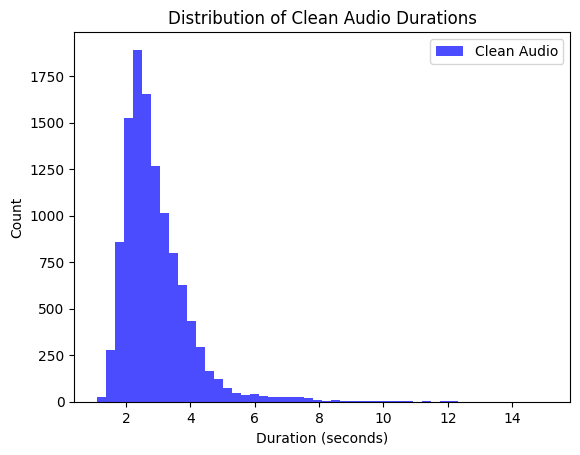

In [21]:
import matplotlib.pyplot as plt

sample_rate = 8e3

# Example for clean audio duration distribution
clean_durations = [librosa.get_duration(y=librosa.load(file, sr=sample_rate)[0], sr=sample_rate) for file in clean_train_filenames]

plt.hist(clean_durations, bins=50, color='blue', alpha=0.7, label='Clean Audio')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Clean Audio Durations')
plt.show()


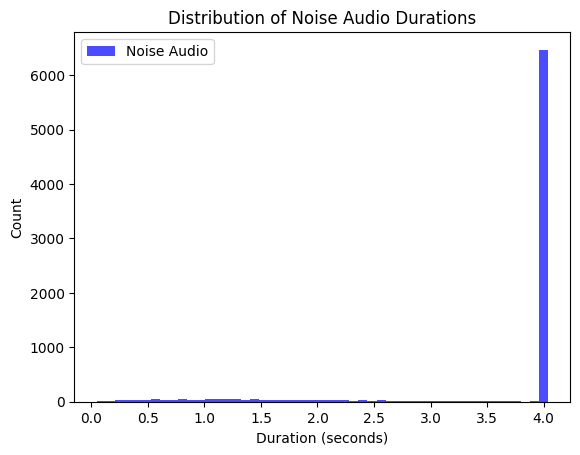

In [ ]:
import matplotlib.pyplot as plt

sample_rate = 8e3

# Example for clean audio duration distribution
clean_durations = [librosa.get_duration(y=librosa.load(file, sr=sample_rate)[0], sr=sample_rate) for file in noise_train_filenames]

plt.hist(clean_durations, bins=50, color='blue', alpha=0.7, label='Noise Audio')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Noise Audio Durations')
plt.show()




```
# This is formatted as code
```

### Spectrogram Visualization:

<ipython-input-29-bb89f76fb988>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(clean_sample), ref=np.max), y_axis='log', x_axis='time')
<ipython-input-29-bb89f76fb988>:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(noisy_sample), ref=np.max), y_axis='log', x_axis='time')


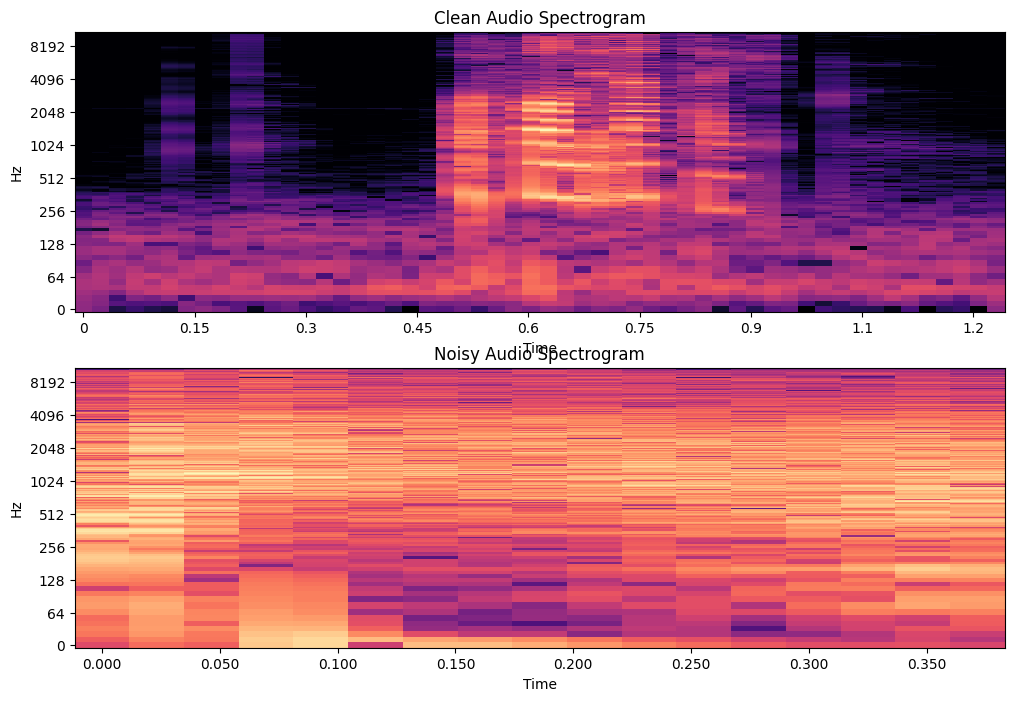

In [ ]:
import librosa.display

# Example for visualizing spectrograms
clean_sample, _ = read_audio(clean_train_filenames[0], sample_rate)
noisy_sample, _ = read_audio(noise_train_filenames[0], sample_rate)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(clean_sample), ref=np.max), y_axis='log', x_axis='time')
plt.title('Clean Audio Spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(noisy_sample), ref=np.max), y_axis='log', x_axis='time')
plt.title('Noisy Audio Spectrogram')

plt.show()


### Class Distribution (for UrbanSound8K)

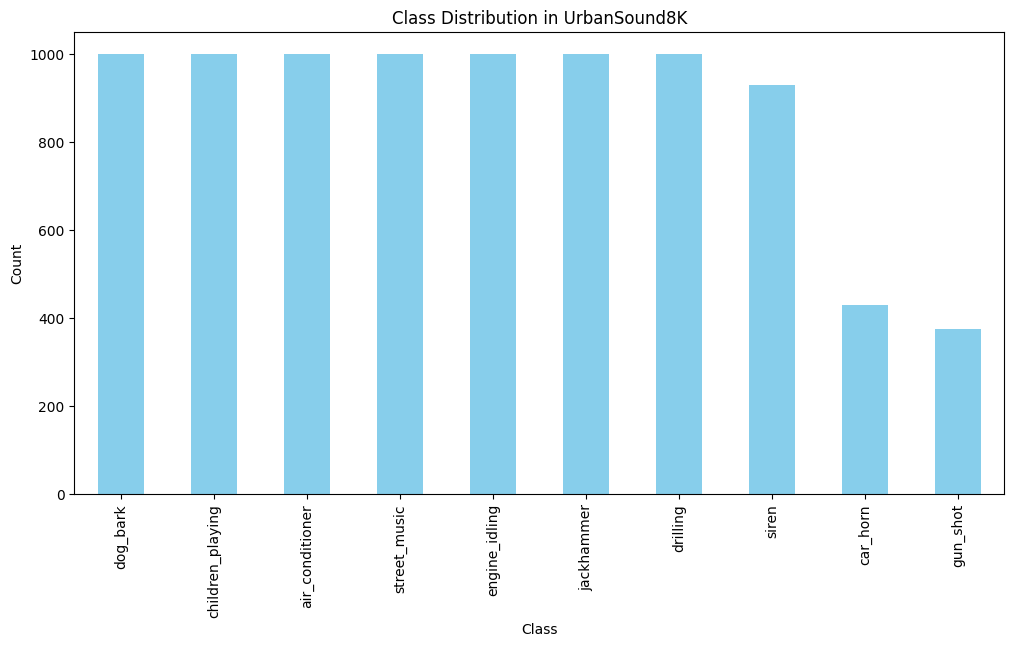

In [ ]:
# Example for class distribution in UrbanSound8K
urbansound_metadata = pd.read_csv(os.path.join(urbansound_basepath, 'UrbanSound8K.csv'))

plt.figure(figsize=(12, 6))
urbansound_metadata['class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution in UrbanSound8K')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### Amplitude distribution

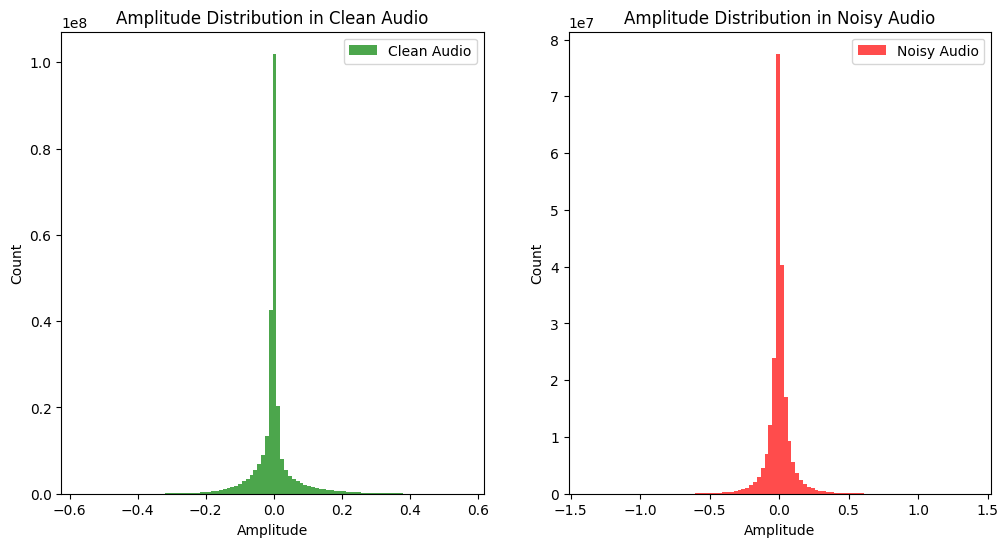

In [ ]:
# Example for amplitude distribution
clean_amplitudes = [librosa.load(file, sr=sample_rate)[0] for file in clean_train_filenames]
noisy_amplitudes = [librosa.load(file, sr=sample_rate)[0] for file in noise_train_filenames]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(np.concatenate(clean_amplitudes), bins=100, color='green', alpha=0.7, label='Clean Audio')
plt.xlabel('Amplitude')
plt.ylabel('Count')
plt.legend()
plt.title('Amplitude Distribution in Clean Audio')

plt.subplot(1, 2, 2)
plt.hist(np.concatenate(noisy_amplitudes), bins=100, color='red', alpha=0.7, label='Noisy Audio')
plt.xlabel('Amplitude')
plt.ylabel('Count')
plt.legend()
plt.title('Amplitude Distribution in Noisy Audio')

plt.show()

### Zero-Crossing Rate Distribution

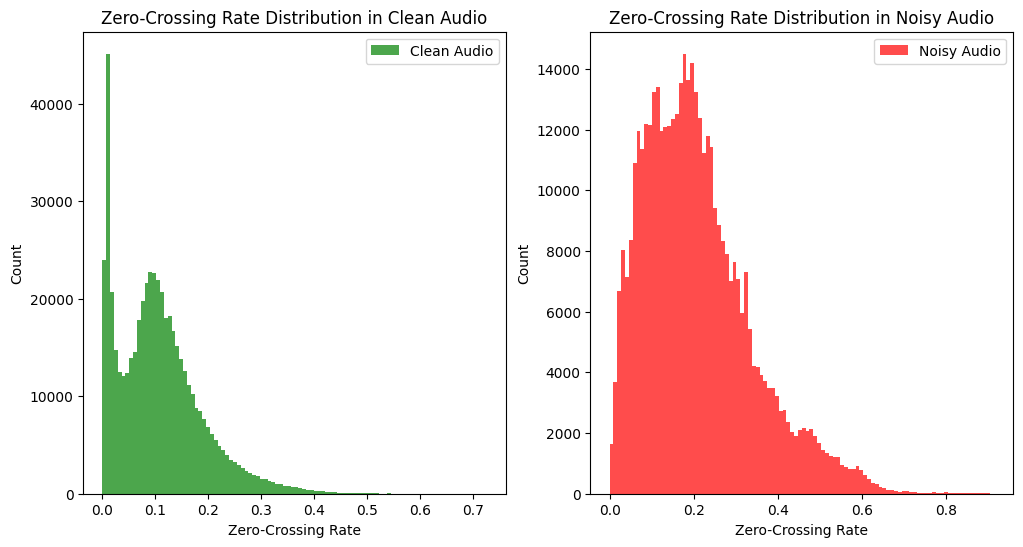

In [ ]:
# Example for zero-crossing rate distribution
clean_zcr = [librosa.feature.zero_crossing_rate(y)[0] for y in clean_amplitudes]
noisy_zcr = [librosa.feature.zero_crossing_rate(y)[0] for y in noisy_amplitudes]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(np.concatenate(clean_zcr), bins=100, color='green', alpha=0.7, label='Clean Audio')
plt.xlabel('Zero-Crossing Rate')
plt.ylabel('Count')
plt.legend()
plt.title('Zero-Crossing Rate Distribution in Clean Audio')

plt.subplot(1, 2, 2)
plt.hist(np.concatenate(noisy_zcr), bins=100, color='red', alpha=0.7, label='Noisy Audio')
plt.xlabel('Zero-Crossing Rate')
plt.ylabel('Count')
plt.legend()
plt.title('Zero-Crossing Rate Distribution in Noisy Audio')

plt.show()


## Train, Val, Test

In [22]:
windowLength = 256
config = {'windowLength': windowLength,
          'overlap': round(0.25 * windowLength),
          'fs': 8000,
          'audio_max_duration': 0.8}

In [23]:
val_dataset = Dataset(clean_val_filenames, noise_val_filenames, **config)
val_dataset.create_tf_record(prefix='val', subset_size=200)

Processing files from: 0 to 200


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()


In [24]:
train_dataset = Dataset(clean_train_filenames, noise_train_filenames, **config)
train_dataset.create_tf_record(prefix='train', subset_size=400)

Processing files from: 0 to 400


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()


Processing files from: 400 to 800
Processing files from: 800 to 1200
Processing files from: 1200 to 1600
Processing files from: 1600 to 2000
Processing files from: 2000 to 2400
Processing files from: 2400 to 2800
Processing files from: 2800 to 3200
Processing files from: 3200 to 3600
Processing files from: 3600 to 4000
Processing files from: 4000 to 4400
Processing files from: 4400 to 4800
Processing files from: 4800 to 5200
Processing files from: 5200 to 5600
Processing files from: 5600 to 6000
Processing files from: 6000 to 6400
Processing files from: 6400 to 6800
Processing files from: 6800 to 7200
Processing files from: 7200 to 7600
Processing files from: 7600 to 8000
Processing files from: 8000 to 8400
Processing files from: 8400 to 8800
Processing files from: 8800 to 9200
Processing files from: 9200 to 9600
Processing files from: 9600 to 10000
Processing files from: 10000 to 10400
Processing files from: 10400 to 10800
Processing files from: 10800 to 11200
Processing files from: 1

In [25]:
## Create Test Set
clean_test_filenames, noise_test_filenames = noisy_speech_dataset.get_test_filenames()
noise_test_filenames = us8K.get_test_filenames()

# of Testing clean files: 824
Class c: 0 has: 100 files
Class c: 1 has: 33 files
Class c: 2 has: 100 files
Class c: 3 has: 100 files
Class c: 4 has: 100 files
Class c: 5 has: 93 files
Class c: 6 has: 32 files
Class c: 7 has: 96 files
Class c: 8 has: 83 files
Class c: 9 has: 100 files
# of Noise testing files: 837


In [26]:
# from pydub import AudioSegment
import IPython

IPython.display.Audio("/content/urbansound8k/fold10/100648-1-0-0.wav")

In [27]:
train_tfrecords_filenames = glob.glob('/content/records/train_*')
np.random.shuffle(train_tfrecords_filenames)
train_tfrecords_filenames = list(train_tfrecords_filenames)
# glob.glob("/kaggle/working/records/val_*")

In [28]:
print(train_tfrecords_filenames)

['/content/records/train_25.tfrecords', '/content/records/train_8.tfrecords', '/content/records/train_22.tfrecords', '/content/records/train_24.tfrecords', '/content/records/train_17.tfrecords', '/content/records/train_4.tfrecords', '/content/records/train_3.tfrecords', '/content/records/train_16.tfrecords', '/content/records/train_14.tfrecords', '/content/records/train_10.tfrecords', '/content/records/train_11.tfrecords', '/content/records/train_13.tfrecords', '/content/records/train_12.tfrecords', '/content/records/train_18.tfrecords', '/content/records/train_21.tfrecords', '/content/records/train_0.tfrecords', '/content/records/train_19.tfrecords', '/content/records/train_28.tfrecords', '/content/records/train_9.tfrecords', '/content/records/train_1.tfrecords', '/content/records/train_15.tfrecords', '/content/records/train_23.tfrecords', '/content/records/train_26.tfrecords', '/content/records/train_2.tfrecords', '/content/records/train_6.tfrecords', '/content/records/train_5.tfreco

In [29]:
val_tfrecords_filenames = glob.glob('/content/records/val_*')

In [30]:
test_tfrecords_filenames = glob.glob('/content/records/test_*')

In [31]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 8e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 8000.0
numFeatures: 129
numSegments: 8


In [32]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

In [33]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512+256)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [34]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 129, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 129, 1, 1), dtype=tf.float32, name=None))>

In [35]:
test_dataset = Dataset(clean_test_filenames, noise_test_filenames, **config)
test_dataset.create_tf_record(prefix='test', subset_size=1, parallel=False)

Processing files from: 0 to 1


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 1 to 2
Processing files from: 2 to 3
Processing files from: 3 to 4
Processing files from: 4 to 5


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 5 to 6
Processing files from: 6 to 7
Processing files from: 7 to 8
Processing files from: 8 to 9
Processing files from: 9 to 10
Processing files from: 10 to 11
Processing files from: 11 to 12


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 12 to 13
Processing files from: 13 to 14
Processing files from: 14 to 15
Processing files from: 15 to 16


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 16 to 17
Processing files from: 17 to 18
Processing files from: 18 to 19
Processing files from: 19 to 20


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 20 to 21
Processing files from: 21 to 22
Processing files from: 22 to 23
Processing files from: 23 to 24


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 24 to 25
Processing files from: 25 to 26
Processing files from: 26 to 27
Processing files from: 27 to 28


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 28 to 29
Processing files from: 29 to 30
Processing files from: 30 to 31
Processing files from: 31 to 32


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 32 to 33
Processing files from: 33 to 34
Processing files from: 34 to 35
Processing files from: 35 to 36


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 36 to 37
Processing files from: 37 to 38
Processing files from: 38 to 39
Processing files from: 39 to 40


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 40 to 41
Processing files from: 41 to 42
Processing files from: 42 to 43
Processing files from: 43 to 44


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 44 to 45
Processing files from: 45 to 46
Processing files from: 46 to 47
Processing files from: 47 to 48


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 48 to 49
Processing files from: 49 to 50
Processing files from: 50 to 51
Processing files from: 51 to 52


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 52 to 53
Processing files from: 53 to 54
Processing files from: 54 to 55
Processing files from: 55 to 56


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 56 to 57
Processing files from: 57 to 58
Processing files from: 58 to 59
Processing files from: 59 to 60


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 60 to 61
Processing files from: 61 to 62
Processing files from: 62 to 63
Processing files from: 63 to 64


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 64 to 65
Processing files from: 65 to 66
Processing files from: 66 to 67


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 67 to 68
Processing files from: 68 to 69
Processing files from: 69 to 70


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 70 to 71
Processing files from: 71 to 72
Processing files from: 72 to 73


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 73 to 74


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 74 to 75
Processing files from: 75 to 76
Processing files from: 76 to 77


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 77 to 78
Processing files from: 78 to 79


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 79 to 80
Processing files from: 80 to 81
Processing files from: 81 to 82


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 82 to 83
Processing files from: 83 to 84


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 84 to 85
Processing files from: 85 to 86
Processing files from: 86 to 87


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 87 to 88
Processing files from: 88 to 89
Processing files from: 89 to 90


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 90 to 91
Processing files from: 91 to 92
Processing files from: 92 to 93


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 93 to 94
Processing files from: 94 to 95
Processing files from: 95 to 96


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 96 to 97
Processing files from: 97 to 98
Processing files from: 98 to 99


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 99 to 100
Processing files from: 100 to 101


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 101 to 102
Processing files from: 102 to 103
Processing files from: 103 to 104


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 104 to 105
Processing files from: 105 to 106
Processing files from: 106 to 107


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 107 to 108
Processing files from: 108 to 109
Processing files from: 109 to 110


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 110 to 111
Processing files from: 111 to 112
Processing files from: 112 to 113


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 113 to 114
Processing files from: 114 to 115


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 115 to 116
Processing files from: 116 to 117
Processing files from: 117 to 118


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 118 to 119
Processing files from: 119 to 120
Processing files from: 120 to 121


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 121 to 122
Processing files from: 122 to 123


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 123 to 124
Processing files from: 124 to 125
Processing files from: 125 to 126


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 126 to 127
Processing files from: 127 to 128
Processing files from: 128 to 129
Processing files from: 129 to 130
Processing files from: 130 to 131


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 131 to 132
Processing files from: 132 to 133
Processing files from: 133 to 134


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 134 to 135
Processing files from: 135 to 136


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 136 to 137
Processing files from: 137 to 138
Processing files from: 138 to 139


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 139 to 140
Processing files from: 140 to 141
Processing files from: 141 to 142
Processing files from: 142 to 143


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 143 to 144
Processing files from: 144 to 145
Processing files from: 145 to 146
Processing files from: 146 to 147


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 147 to 148
Processing files from: 148 to 149
Processing files from: 149 to 150
Processing files from: 150 to 151


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 151 to 152
Processing files from: 152 to 153
Processing files from: 153 to 154
Processing files from: 154 to 155


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 155 to 156
Processing files from: 156 to 157
Processing files from: 157 to 158
Processing files from: 158 to 159


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 159 to 160
Processing files from: 160 to 161
Processing files from: 161 to 162
Processing files from: 162 to 163


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 163 to 164
Processing files from: 164 to 165
Processing files from: 165 to 166
Processing files from: 166 to 167


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 167 to 168
Processing files from: 168 to 169
Processing files from: 169 to 170
Processing files from: 170 to 171


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 171 to 172
Processing files from: 172 to 173
Processing files from: 173 to 174
Processing files from: 174 to 175
Processing files from: 175 to 176


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 176 to 177
Processing files from: 177 to 178
Processing files from: 178 to 179
Processing files from: 179 to 180
Processing files from: 180 to 181


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 181 to 182
Processing files from: 182 to 183
Processing files from: 183 to 184


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 184 to 185
Processing files from: 185 to 186
Processing files from: 186 to 187


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 187 to 188
Processing files from: 188 to 189
Processing files from: 189 to 190


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 190 to 191
Processing files from: 191 to 192
Processing files from: 192 to 193
Processing files from: 193 to 194


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 194 to 195
Processing files from: 195 to 196
Processing files from: 196 to 197
Processing files from: 197 to 198


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 198 to 199
Processing files from: 199 to 200
Processing files from: 200 to 201


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 201 to 202
Processing files from: 202 to 203
Processing files from: 203 to 204
Processing files from: 204 to 205


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 205 to 206
Processing files from: 206 to 207
Processing files from: 207 to 208
Processing files from: 208 to 209


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 209 to 210
Processing files from: 210 to 211
Processing files from: 211 to 212
Processing files from: 212 to 213


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 213 to 214
Processing files from: 214 to 215
Processing files from: 215 to 216
Processing files from: 216 to 217


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 217 to 218
Processing files from: 218 to 219
Processing files from: 219 to 220
Processing files from: 220 to 221


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 221 to 222
Processing files from: 222 to 223
Processing files from: 223 to 224
Processing files from: 224 to 225


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 225 to 226
Processing files from: 226 to 227
Processing files from: 227 to 228
Processing files from: 228 to 229


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 229 to 230
Processing files from: 230 to 231
Processing files from: 231 to 232
Processing files from: 232 to 233


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 233 to 234
Processing files from: 234 to 235
Processing files from: 235 to 236
Processing files from: 236 to 237


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 237 to 238
Processing files from: 238 to 239
Processing files from: 239 to 240
Processing files from: 240 to 241


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 241 to 242
Processing files from: 242 to 243
Processing files from: 243 to 244
Processing files from: 244 to 245


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 245 to 246
Processing files from: 246 to 247
Processing files from: 247 to 248
Processing files from: 248 to 249


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 249 to 250
Processing files from: 250 to 251
Processing files from: 251 to 252
Processing files from: 252 to 253


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 253 to 254
Processing files from: 254 to 255
Processing files from: 255 to 256
Processing files from: 256 to 257
Processing files from: 257 to 258
Processing files from: 258 to 259
Processing files from: 259 to 260


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 260 to 261
Processing files from: 261 to 262
Processing files from: 262 to 263
Processing files from: 263 to 264


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 264 to 265
Processing files from: 265 to 266
Processing files from: 266 to 267
Processing files from: 267 to 268


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 268 to 269
Processing files from: 269 to 270
Processing files from: 270 to 271
Processing files from: 271 to 272


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 272 to 273
Processing files from: 273 to 274
Processing files from: 274 to 275
Processing files from: 275 to 276


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 276 to 277
Processing files from: 277 to 278
Processing files from: 278 to 279
Processing files from: 279 to 280


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 280 to 281
Processing files from: 281 to 282
Processing files from: 282 to 283
Processing files from: 283 to 284


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 284 to 285
Processing files from: 285 to 286
Processing files from: 286 to 287
Processing files from: 287 to 288


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 288 to 289
Processing files from: 289 to 290
Processing files from: 290 to 291
Processing files from: 291 to 292


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 292 to 293
Processing files from: 293 to 294
Processing files from: 294 to 295
Processing files from: 295 to 296


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 296 to 297
Processing files from: 297 to 298
Processing files from: 298 to 299
Processing files from: 299 to 300


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 300 to 301
Processing files from: 301 to 302
Processing files from: 302 to 303
Processing files from: 303 to 304


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 304 to 305
Processing files from: 305 to 306
Processing files from: 306 to 307
Processing files from: 307 to 308


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 308 to 309
Processing files from: 309 to 310
Processing files from: 310 to 311


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 311 to 312
Processing files from: 312 to 313
Processing files from: 313 to 314


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 314 to 315
Processing files from: 315 to 316
Processing files from: 316 to 317


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 317 to 318
Processing files from: 318 to 319
Processing files from: 319 to 320


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 320 to 321
Processing files from: 321 to 322
Processing files from: 322 to 323


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 323 to 324
Processing files from: 324 to 325
Processing files from: 325 to 326


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 326 to 327
Processing files from: 327 to 328
Processing files from: 328 to 329


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 329 to 330
Processing files from: 330 to 331
Processing files from: 331 to 332


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 332 to 333
Processing files from: 333 to 334
Processing files from: 334 to 335


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 335 to 336
Processing files from: 336 to 337
Processing files from: 337 to 338


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 338 to 339
Processing files from: 339 to 340
Processing files from: 340 to 341
Processing files from: 341 to 342


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 342 to 343
Processing files from: 343 to 344
Processing files from: 344 to 345


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 345 to 346
Processing files from: 346 to 347
Processing files from: 347 to 348


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 348 to 349
Processing files from: 349 to 350


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 350 to 351
Processing files from: 351 to 352


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 352 to 353
Processing files from: 353 to 354


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 354 to 355
Processing files from: 355 to 356
Processing files from: 356 to 357


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 357 to 358
Processing files from: 358 to 359
Processing files from: 359 to 360


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 360 to 361
Processing files from: 361 to 362


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 362 to 363
Processing files from: 363 to 364
Processing files from: 364 to 365


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 365 to 366
Processing files from: 366 to 367
Processing files from: 367 to 368


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 368 to 369
Processing files from: 369 to 370
Processing files from: 370 to 371


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 371 to 372
Processing files from: 372 to 373
Processing files from: 373 to 374
Processing files from: 374 to 375

<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i


Processing files from: 375 to 376
Processing files from: 376 to 377


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 377 to 378
Processing files from: 378 to 379
Processing files from: 379 to 380


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 380 to 381
Processing files from: 381 to 382
Processing files from: 382 to 383


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 383 to 384
Processing files from: 384 to 385
Processing files from: 385 to 386
Processing files from: 386 to 387


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 387 to 388
Processing files from: 388 to 389
Processing files from: 389 to 390


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 390 to 391
Processing files from: 391 to 392
Processing files from: 392 to 393
Processing files from: 393 to 394


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 394 to 395
Processing files from: 395 to 396
Processing files from: 396 to 397
Processing files from: 397 to 398


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 398 to 399
Processing files from: 399 to 400
Processing files from: 400 to 401
Processing files from: 401 to 402


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 402 to 403
Processing files from: 403 to 404
Processing files from: 404 to 405
Processing files from: 405 to 406


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 406 to 407
Processing files from: 407 to 408
Processing files from: 408 to 409
Processing files from: 409 to 410


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 410 to 411
Processing files from: 411 to 412
Processing files from: 412 to 413
Processing files from: 413 to 414


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 414 to 415
Processing files from: 415 to 416
Processing files from: 416 to 417
Processing files from: 417 to 418


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 418 to 419
Processing files from: 419 to 420
Processing files from: 420 to 421


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 421 to 422
Processing files from: 422 to 423
Processing files from: 423 to 424
Processing files from: 424 to 425


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 425 to 426
Processing files from: 426 to 427
Processing files from: 427 to 428
Processing files from: 428 to 429


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 429 to 430
Processing files from: 430 to 431
Processing files from: 431 to 432
Processing files from: 432 to 433
Processing files from: 433 to 434
Processing files from: 434 to 435
Processing files from: 435 to 436
Processing files from: 436 to 437


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 437 to 438
Processing files from: 438 to 439
Processing files from: 439 to 440
Processing files from: 440 to 441


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 441 to 442
Processing files from: 442 to 443
Processing files from: 443 to 444
Processing files from: 444 to 445


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 445 to 446
Processing files from: 446 to 447
Processing files from: 447 to 448
Processing files from: 448 to 449


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 449 to 450
Processing files from: 450 to 451
Processing files from: 451 to 452
Processing files from: 452 to 453


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 453 to 454
Processing files from: 454 to 455
Processing files from: 455 to 456
Processing files from: 456 to 457


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 457 to 458
Processing files from: 458 to 459
Processing files from: 459 to 460
Processing files from: 460 to 461


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 461 to 462
Processing files from: 462 to 463
Processing files from: 463 to 464
Processing files from: 464 to 465
Processing files from: 465 to 466


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 466 to 467
Processing files from: 467 to 468
Processing files from: 468 to 469
Processing files from: 469 to 470


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 470 to 471
Processing files from: 471 to 472
Processing files from: 472 to 473
Processing files from: 473 to 474


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 474 to 475
Processing files from: 475 to 476
Processing files from: 476 to 477
Processing files from: 477 to 478


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 478 to 479
Processing files from: 479 to 480
Processing files from: 480 to 481
Processing files from: 481 to 482


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 482 to 483
Processing files from: 483 to 484
Processing files from: 484 to 485
Processing files from: 485 to 486


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 486 to 487
Processing files from: 487 to 488
Processing files from: 488 to 489
Processing files from: 489 to 490


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 490 to 491
Processing files from: 491 to 492
Processing files from: 492 to 493
Processing files from: 493 to 494


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 494 to 495
Processing files from: 495 to 496
Processing files from: 496 to 497
Processing files from: 497 to 498


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 498 to 499
Processing files from: 499 to 500
Processing files from: 500 to 501
Processing files from: 501 to 502


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 502 to 503
Processing files from: 503 to 504
Processing files from: 504 to 505
Processing files from: 505 to 506


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 506 to 507
Processing files from: 507 to 508
Processing files from: 508 to 509


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 509 to 510
Processing files from: 510 to 511


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 511 to 512
Processing files from: 512 to 513
Processing files from: 513 to 514
Processing files from: 514 to 515


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 515 to 516
Processing files from: 516 to 517
Processing files from: 517 to 518
Processing files from: 518 to 519
Processing files from: 519 to 520
Processing files from: 520 to 521
Processing files from: 521 to 522


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 522 to 523
Processing files from: 523 to 524
Processing files from: 524 to 525


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 525 to 526
Processing files from: 526 to 527
Processing files from: 527 to 528
Processing files from: 528 to 529


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 529 to 530
Processing files from: 530 to 531
Processing files from: 531 to 532
Processing files from: 532 to 533


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 533 to 534
Processing files from: 534 to 535
Processing files from: 535 to 536
Processing files from: 536 to 537


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 537 to 538
Processing files from: 538 to 539
Processing files from: 539 to 540
Processing files from: 540 to 541


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 541 to 542
Processing files from: 542 to 543
Processing files from: 543 to 544
Processing files from: 544 to 545


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 545 to 546
Processing files from: 546 to 547
Processing files from: 547 to 548
Processing files from: 548 to 549
Processing files from: 549 to 550


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 550 to 551
Processing files from: 551 to 552


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 552 to 553
Processing files from: 553 to 554


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 554 to 555
Processing files from: 555 to 556
Processing files from: 556 to 557


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 557 to 558
Processing files from: 558 to 559
Processing files from: 559 to 560


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 560 to 561
Processing files from: 561 to 562
Processing files from: 562 to 563


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 563 to 564
Processing files from: 564 to 565
Processing files from: 565 to 566


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 566 to 567
Processing files from: 567 to 568
Processing files from: 568 to 569


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 569 to 570
Processing files from: 570 to 571
Processing files from: 571 to 572


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 572 to 573
Processing files from: 573 to 574
Processing files from: 574 to 575


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 575 to 576
Processing files from: 576 to 577
Processing files from: 577 to 578


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 578 to 579
Processing files from: 579 to 580


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 580 to 581
Processing files from: 581 to 582
Processing files from: 582 to 583


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 583 to 584
Processing files from: 584 to 585
Processing files from: 585 to 586


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 586 to 587
Processing files from: 587 to 588
Processing files from: 588 to 589


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 589 to 590
Processing files from: 590 to 591
Processing files from: 591 to 592


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 592 to 593
Processing files from: 593 to 594
Processing files from: 594 to 595


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 595 to 596
Processing files from: 596 to 597


<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()


Processing files from: 597 to 598
Processing files from: 598 to 599


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 599 to 600
Processing files from: 600 to 601
Processing files from: 601 to 602


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 602 to 603
Processing files from: 603 to 604
Processing files from: 604 to 605


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 605 to 606
Processing files from: 606 to 607
Processing files from: 607 to 608


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 608 to 609
Processing files from: 609 to 610
Processing files from: 610 to 611


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 611 to 612
Processing files from: 612 to 613
Processing files from: 613 to 614


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 614 to 615
Processing files from: 615 to 616
Processing files from: 616 to 617


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 617 to 618
Processing files from: 618 to 619
Processing files from: 619 to 620


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 620 to 621
Processing files from: 621 to 622
Processing files from: 622 to 623
Processing files from: 623 to 624


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 624 to 625
Processing files from: 625 to 626
Processing files from: 626 to 627
Processing files from: 627 to 628
Processing files from: 628 to 629


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 629 to 630
Processing files from: 630 to 631
Processing files from: 631 to 632
Processing files from: 632 to 633


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 633 to 634
Processing files from: 634 to 635
Processing files from: 635 to 636
Processing files from: 636 to 637
Processing files from: 637 to 638


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 638 to 639
Processing files from: 639 to 640
Processing files from: 640 to 641
Processing files from: 641 to 642


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 642 to 643
Processing files from: 643 to 644
Processing files from: 644 to 645
Processing files from: 645 to 646


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 646 to 647
Processing files from: 647 to 648
Processing files from: 648 to 649
Processing files from: 649 to 650


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 650 to 651
Processing files from: 651 to 652
Processing files from: 652 to 653
Processing files from: 653 to 654


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 654 to 655
Processing files from: 655 to 656
Processing files from: 656 to 657
Processing files from: 657 to 658


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 658 to 659
Processing files from: 659 to 660
Processing files from: 660 to 661
Processing files from: 661 to 662


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 662 to 663
Processing files from: 663 to 664
Processing files from: 664 to 665
Processing files from: 665 to 666


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 666 to 667
Processing files from: 667 to 668
Processing files from: 668 to 669
Processing files from: 669 to 670


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 670 to 671
Processing files from: 671 to 672
Processing files from: 672 to 673
Processing files from: 673 to 674


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 674 to 675
Processing files from: 675 to 676
Processing files from: 676 to 677
Processing files from: 677 to 678


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 678 to 679
Processing files from: 679 to 680
Processing files from: 680 to 681
Processing files from: 681 to 682


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 682 to 683
Processing files from: 683 to 684
Processing files from: 684 to 685
Processing files from: 685 to 686


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 686 to 687
Processing files from: 687 to 688
Processing files from: 688 to 689
Processing files from: 689 to 690
Processing files from: 690 to 691


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 691 to 692
Processing files from: 692 to 693
Processing files from: 693 to 694
Processing files from: 694 to 695


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 695 to 696
Processing files from: 696 to 697
Processing files from: 697 to 698
Processing files from: 698 to 699
Processing files from: 699 to 700


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 700 to 701
Processing files from: 701 to 702
Processing files from: 702 to 703
Processing files from: 703 to 704
Processing files from: 704 to 705
Processing files from: 705 to 706
Processing files from: 706 to 707
Processing files from: 707 to 708


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 708 to 709
Processing files from: 709 to 710
Processing files from: 710 to 711
Processing files from: 711 to 712


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 712 to 713
Processing files from: 713 to 714
Processing files from: 714 to 715
Processing files from: 715 to 716


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 716 to 717
Processing files from: 717 to 718
Processing files from: 718 to 719
Processing files from: 719 to 720


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 720 to 721
Processing files from: 721 to 722
Processing files from: 722 to 723
Processing files from: 723 to 724


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 724 to 725
Processing files from: 725 to 726
Processing files from: 726 to 727
Processing files from: 727 to 728


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 728 to 729
Processing files from: 729 to 730
Processing files from: 730 to 731
Processing files from: 731 to 732


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 732 to 733
Processing files from: 733 to 734
Processing files from: 734 to 735
Processing files from: 735 to 736


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 736 to 737
Processing files from: 737 to 738
Processing files from: 738 to 739
Processing files from: 739 to 740


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 740 to 741
Processing files from: 741 to 742
Processing files from: 742 to 743
Processing files from: 743 to 744


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 744 to 745
Processing files from: 745 to 746
Processing files from: 746 to 747
Processing files from: 747 to 748


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 748 to 749
Processing files from: 749 to 750
Processing files from: 750 to 751
Processing files from: 751 to 752
Processing files from: 752 to 753


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 753 to 754
Processing files from: 754 to 755
Processing files from: 755 to 756
Processing files from: 756 to 757


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 757 to 758
Processing files from: 758 to 759
Processing files from: 759 to 760
Processing files from: 760 to 761


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 761 to 762
Processing files from: 762 to 763
Processing files from: 763 to 764
Processing files from: 764 to 765


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 765 to 766
Processing files from: 766 to 767
Processing files from: 767 to 768
Processing files from: 768 to 769


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 769 to 770
Processing files from: 770 to 771
Processing files from: 771 to 772


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 772 to 773
Processing files from: 773 to 774
Processing files from: 774 to 775
Processing files from: 775 to 776


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 776 to 777
Processing files from: 777 to 778
Processing files from: 778 to 779


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 779 to 780
Processing files from: 780 to 781
Processing files from: 781 to 782
Processing files from: 782 to 783


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 783 to 784
Processing files from: 784 to 785
Processing files from: 785 to 786
Processing files from: 786 to 787


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 787 to 788
Processing files from: 788 to 789
Processing files from: 789 to 790
Processing files from: 790 to 791


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 791 to 792
Processing files from: 792 to 793
Processing files from: 793 to 794


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 794 to 795
Processing files from: 795 to 796
Processing files from: 796 to 797


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 797 to 798
Processing files from: 798 to 799
Processing files from: 799 to 800


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 800 to 801
Processing files from: 801 to 802
Processing files from: 802 to 803
Processing files from: 803 to 804
Processing files from: 804 to 805


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 805 to 806
Processing files from: 806 to 807
Processing files from: 807 to 808


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 808 to 809
Processing files from: 809 to 810
Processing files from: 810 to 811


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 811 to 812
Processing files from: 812 to 813
Processing files from: 813 to 814


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 814 to 815
Processing files from: 815 to 816
Processing files from: 816 to 817


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 817 to 818
Processing files from: 818 to 819
Processing files from: 819 to 820


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

Processing files from: 820 to 821
Processing files from: 821 to 822
Processing files from: 822 to 823
Processing files from: 823 to 824


<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:89: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:90: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
<ipython-input-2-fff69c46c627>:91: DeprecationWarning: tostring() is deprecated. Use tobytes() i

In [36]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

In [37]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 129, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 129, 1, 1), dtype=tf.float32, name=None))>

## Model Building

### Custom Model 1

In [38]:
!pip install keras-rectified-adam

  Preparing metadata (setup.py) ... done
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8254 sha256=b43e5cf1223ee59eb54bfe6a61bf58a75bb775c3e2d129aeb46eda15daeac070
  Stored in directory: /root/.cache/pip/wheels/24/fe/0f/dcf898210ceef6ae45cea51d3d27765f38bce2b4dc8e88245f
Successfully built keras-rectified-adam


In [40]:
from keras_radam import RAdam

In [41]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17465883010435223203
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14410383360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14496547176048272117
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

In [43]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [44]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
    x = Activation('relu')(x)
    if use_bn:
        x = BatchNormalization()(x)
        return x

In [45]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    shortcut = x
    in_channels = x.shape[-1]

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

    return shortcut + x

In [46]:
def psnr_metric(y_true, y_pred):
    max_pixel = 1.0  # Assuming the audio signal is normalized between 0 and 1
    mse = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred))
    psnr = 20 * tf.keras.backend.log(max_pixel / tf.keras.backend.sqrt(mse)) / tf.keras.backend.log(10.0)
    return psnr

In [47]:
def build_model(l2_strength):
    inputs = Input(shape=[numFeatures, numSegments, 1])
    x = inputs

    # -----
    x = tf.keras.layers.ZeroPadding2D(((4, 4), (0, 0)))(x)
    x = Conv2D(filters=18, kernel_size=[9, 8], strides=[1, 1], padding='valid', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip0 = Conv2D(filters=30, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----
    x = Conv2D(filters=18, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip1 = Conv2D(filters=30, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip1
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip0
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129, 1],
               strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    # optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'),  psnr_metric])
    return model

In [48]:
model = build_model(l2_strength=0.0)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 129, 8, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 137, 8, 1)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 129, 1, 18)           1296      ['zero_padding2d[0][0]']      
                                                                                                  
 activation (Activation)     (None, 129, 1, 18)           0         ['conv2d[0][0]']          

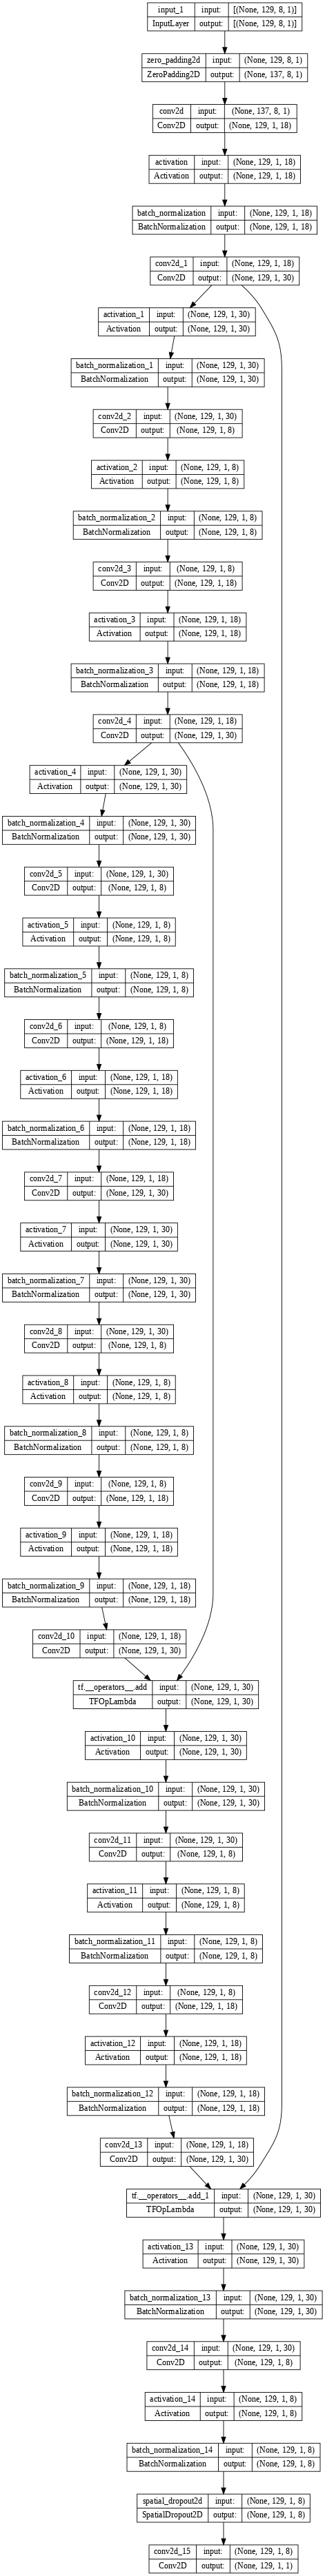

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [50]:
# model.load_weights('drive/My Drive/datasets/dataset_v2/denoiser_cnn_log_mel_generator.h5')
baseline_val_loss = model.evaluate(test_dataset)[0]
print(baseline_val_loss)

40/40 [==============================] - 13s 38ms/step - loss: 0.8294 - rmse: 0.9107 - psnr_metric: 0.8735
0.829429030418396


In [51]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [52]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=baseline_val_loss, mode="auto")

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/speech_denoiser.h5',
                                                         monitor='val_loss', save_best_only=True)

In [53]:
model.fit(train_dataset,
         steps_per_epoch=600,
         validation_data=test_dataset,
         epochs=10,
         callbacks=[early_stopping_callback, checkpoint_callback]
        )

Epoch 1/10
600/600 [==============================] - ETA: 0s - loss: 0.3907 - rmse: 0.6251 - psnr_metric: 4.6258

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 54s 71ms/step - loss: 0.3907 - rmse: 0.6251 - psnr_metric: 4.6258 - val_loss: 0.2116 - val_rmse: 0.4601 - val_psnr_metric: 6.7905
Epoch 2/10
600/600 [==============================] - 45s 76ms/step - loss: 0.2193 - rmse: 0.4683 - psnr_metric: 6.6012 - val_loss: 0.1702 - val_rmse: 0.4125 - val_psnr_metric: 7.7655
Epoch 3/10
600/600 [==============================] - 43s 72ms/step - loss: 0.1920 - rmse: 0.4382 - psnr_metric: 7.1717 - val_loss: 0.1515 - val_rmse: 0.3892 - val_psnr_metric: 8.2810
Epoch 4/10
600/600 [==============================] - 46s 77ms/step - loss: 0.1758 - rmse: 0.4193 - psnr_metric: 7.5539 - val_loss: 0.1502 - val_rmse: 0.3876 - val_psnr_metric: 8.3020
Epoch 5/10
600/600 [==============================] - 41s 68ms/step - loss: 0.1648 - rmse: 0.4060 - psnr_metric: 7.8346 - val_loss: 0.1391 - val_rmse: 0.3729 - val_psnr_metric: 8.6484
Epoch 6/10
600/600 [==============================] - 44s 74ms/step - loss: 0.1604 - rmse: 

In [54]:
# Assuming you have a trained model named 'model'
model.save("/content/drive/MyDrive/Projects/denoising/STFTFullyConvolutional.h5")

In [55]:
def read_audio(filepath, sample_rate, normalize=True):
    # print(f"Reading: {filepath}").
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr

def add_noise_to_clean_audio(clean_audio, noise_signal):
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [56]:
cleanAudio, sr = read_audio('/content/noisy_speech/clean_testset_wav/p232_001.wav', sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.30532587


In [57]:
noiseAudio, sr = read_audio(os.path.join('/content/urbansound8k', 'fold6', '108638-9-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.2976664


In [58]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 1.086894e-06 Max: 9.639375


In [59]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [60]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [61]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 218)


In [62]:
predictors = prepare_input_features(noise_stft_features)

In [63]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (218, 129, 8, 1)


In [64]:
# model = model.loa
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

7/7 [==============================] - 1s 24ms/step
(218, 129, 1, 1)


In [65]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [66]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.23170064 Max: 0.278952


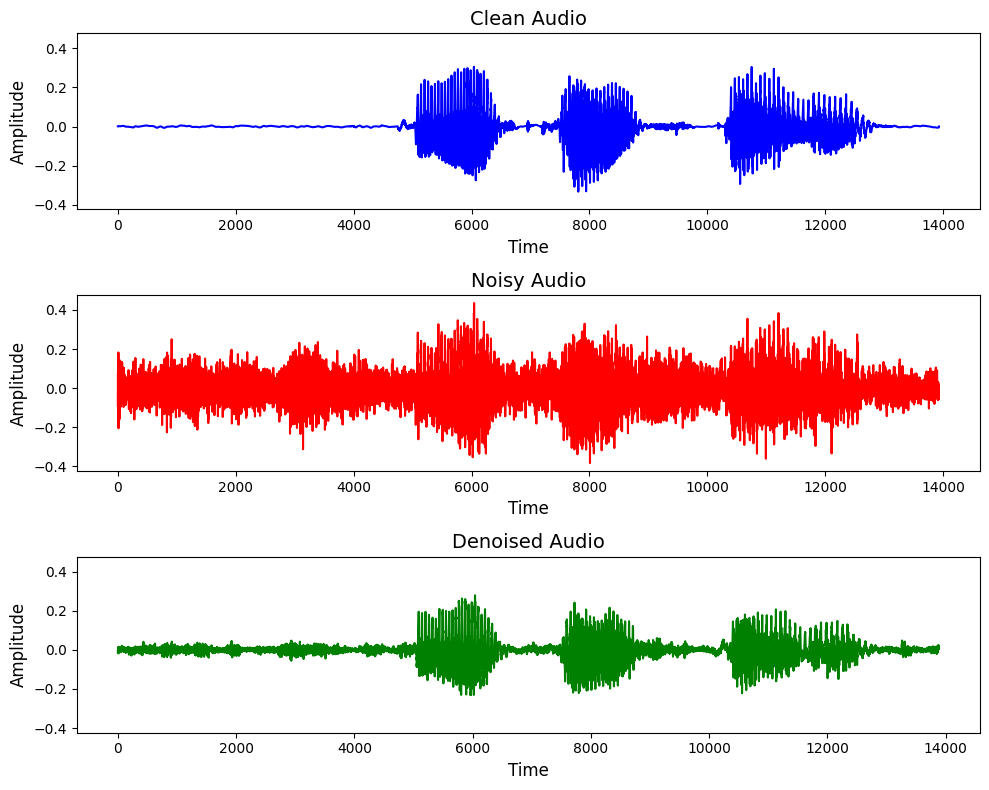

In [67]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(10, 8))

# Plot clean audio
ax1.plot(cleanAudio, color='b')
ax1.set_title("Clean Audio", fontsize=14)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("Amplitude", fontsize=12)

# Plot noisy audio
ax2.plot(noisyAudio, color='r')
ax2.set_title("Noisy Audio", fontsize=14)
ax2.set_xlabel("Time", fontsize=12)
ax2.set_ylabel("Amplitude", fontsize=12)

# Plot denoised audio
ax3.plot(denoisedAudioFullyConvolutional, color='g')
ax3.set_title("Denoised Audio", fontsize=14)
ax3.set_xlabel("Time", fontsize=12)
ax3.set_ylabel("Amplitude", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### ResNet Model

In [68]:
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Activation, Add
from tensorflow.keras import Model

def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def res_block(x, filters, kernel_size, strides, padding='same'):
    shortcut = x

    # 1x1 convolution in the shortcut path
    shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, use_bias=False,
                      kernel_regularizer=tf.keras.regularizers.l2(0.0006))(shortcut)

    x = conv_block(x, filters, kernel_size, strides, padding)
    x = conv_block(x, filters, kernel_size, 1, padding)  # Strides set to 1 for the second convolution
    x = Add()([x, shortcut])
    return x


def build_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs
    x = tf.keras.layers.ZeroPadding2D(((4, 4), (0, 0)))(x)

    # Initial convolution
    # x = Conv2D(filters=18, kernel_size=[9, 8], strides=[1, 1], padding='same', use_bias=False,
    #            kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
    # x = Activation('relu')(x)
    # x = BatchNormalization()(x)

    x = Conv2D(filters=18, kernel_size=[9, 8], strides=[1, 1], padding='valid', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(0.0))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # Residual blocks
    x = res_block(x, filters=30, kernel_size=[5, 1], strides=[1, 1])
    x = res_block(x, filters=8, kernel_size=[9, 1], strides=[1, 1])
    x = res_block(x, filters=30, kernel_size=[5, 1], strides=[1, 1])
    x = res_block(x, filters=8, kernel_size=[9, 1], strides=[1, 1])
    x = res_block(x, filters=30, kernel_size=[5, 1], strides=[1, 1])
    x = res_block(x, filters=8, kernel_size=[9, 1], strides=[1, 1])

    # Spatial Dropout and final convolution
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129, 1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'),psnr_metric])
    return model

resnet_model = build_resnet_model(input_shape=(129, 8, 1))
resnet_model.summary()

# Continue with the rest of your training code...

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 129, 8, 1)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 137, 8, 1)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_16 (Conv2D)          (None, 129, 1, 18)           1296      ['zero_padding2d_1[0][0]']    
                                                                                                  
 activation_15 (Activation)  (None, 129, 1, 18)           0         ['conv2d_16[0][0]']     

In [69]:
resnet_model.fit(train_dataset,
                 steps_per_epoch=600,
                 validation_data=test_dataset,
                 epochs=15,
                 callbacks=[early_stopping_callback, checkpoint_callback]
                )

Epoch 1/15
600/600 [==============================] - 52s 73ms/step - loss: 0.5686 - rmse: 0.6363 - psnr_metric: 4.5061 - val_loss: 0.3726 - val_rmse: 0.4680 - val_psnr_metric: 6.6258
Epoch 2/15
600/600 [==============================] - 44s 74ms/step - loss: 0.3705 - rmse: 0.4786 - psnr_metric: 6.4097 - val_loss: 0.3162 - val_rmse: 0.4322 - val_psnr_metric: 7.3240
Epoch 3/15
600/600 [==============================] - 45s 75ms/step - loss: 0.3188 - rmse: 0.4480 - psnr_metric: 6.9790 - val_loss: 0.2886 - val_rmse: 0.4257 - val_psnr_metric: 7.4614
Epoch 4/15
600/600 [==============================] - 45s 74ms/step - loss: 0.2801 - rmse: 0.4265 - psnr_metric: 7.4062 - val_loss: 0.2445 - val_rmse: 0.3936 - val_psnr_metric: 8.1597
Epoch 5/15
600/600 [==============================] - 40s 66ms/step - loss: 0.2527 - rmse: 0.4128 - psnr_metric: 7.6906 - val_loss: 0.2220 - val_rmse: 0.3826 - val_psnr_metric: 8.4166
Epoch 6/15
600/600 [==============================] - 48s 80ms/step - loss: 0.23

In [90]:
# Assuming you have a trained model named 'model'
resnet_model.save("/content/drive/MyDrive/Projects/denoising/resnet.h5")

In [71]:
cleanAudio, sr = read_audio('/content/noisy_speech/clean_testset_wav/p232_001.wav', sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.30532587


In [72]:
noiseAudio, sr = read_audio(os.path.join('/content/urbansound8k', 'fold6', '108638-9-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.2976664


In [73]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 1.086894e-06 Max: 9.639375


In [74]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [75]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [76]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 218)


In [77]:
predictors = prepare_input_features(noise_stft_features)

In [78]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (218, 129, 8, 1)


In [79]:
# model = model.loa
resnet_model_pred = resnet_model.predict(predictors)
print(resnet_model_pred.shape)

7/7 [==============================] - 1s 35ms/step
(218, 129, 1, 1)


In [80]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [81]:
denoisedAudioFullyConvolutional = revert_features_to_audio(resnet_model_pred, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.2888896 Max: 0.26088026


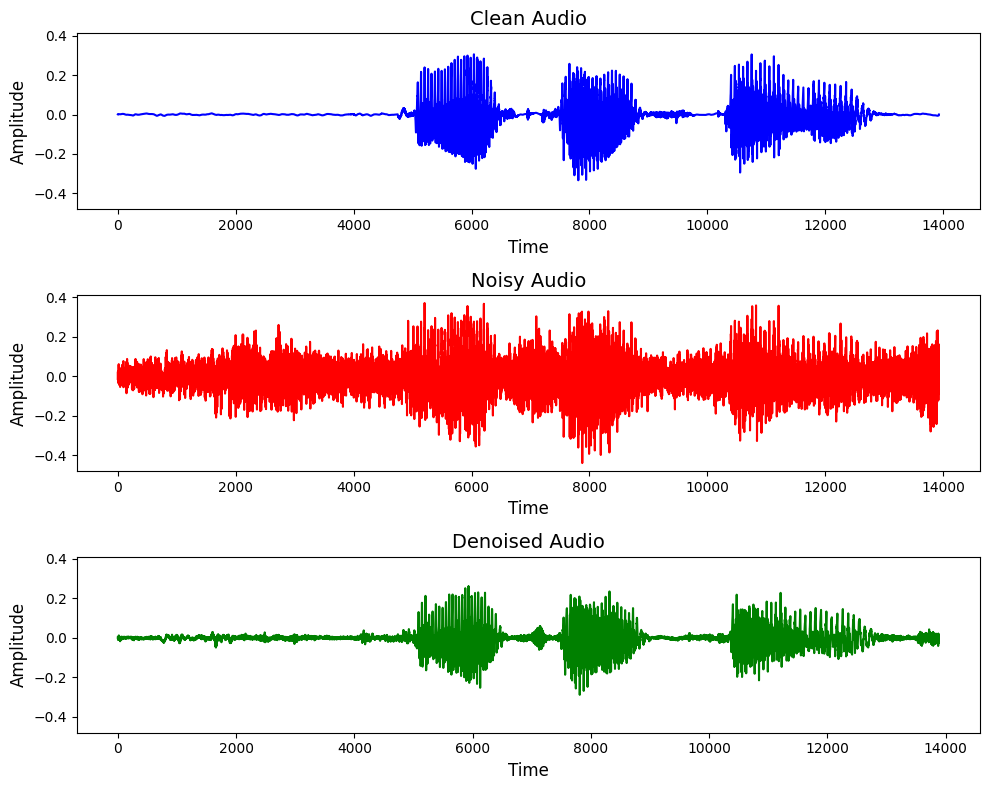

In [82]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(10, 8))

# Plot clean audio
ax1.plot(cleanAudio, color='b')
ax1.set_title("Clean Audio", fontsize=14)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("Amplitude", fontsize=12)

# Plot noisy audio
ax2.plot(noisyAudio, color='r')
ax2.set_title("Noisy Audio", fontsize=14)
ax2.set_xlabel("Time", fontsize=12)
ax2.set_ylabel("Amplitude", fontsize=12)

# Plot denoised audio
ax3.plot(denoisedAudioFullyConvolutional, color='g')
ax3.set_title("Denoised Audio", fontsize=14)
ax3.set_xlabel("Time", fontsize=12)
ax3.set_ylabel("Amplitude", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Custom Model 3

With LeakyReLU as activation and Dropout layers

In [83]:
from tensorflow.keras.layers import MaxPooling2D, LeakyReLU, Dropout

def build_modified_model(l2_strength, dropout_rate):
    inputs = Input(shape=[numFeatures, numSegments, 1])
    x = inputs

    x = tf.keras.layers.ZeroPadding2D(((4, 4), (0, 0)))(x)
    x = Conv2D(filters=18, kernel_size=[9, 8], strides=[1, 1], padding='valid', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(0.0))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    skip0 = Conv2D(filters=64, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(skip0)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=16, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=32, kernel_size=[7, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    skip1 = Conv2D(filters=64, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(skip1)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=16, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=32, kernel_size=[7, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=64, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=16, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=32, kernel_size=[7, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=64, kernel_size=[5, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip1
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=16, kernel_size=[9, 1], strides=[1, 1], padding='same', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=1, kernel_size=[129, 1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', psnr_metric])

    return model

# Example usage:
modified_model = build_modified_model(l2_strength=0.001, dropout_rate=0.3)

In [84]:
modified_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 129, 8, 1)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 137, 8, 1)            0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_36 (Conv2D)          (None, 129, 1, 18)           1296      ['zero_padding2d_2[0][0]']    
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 129, 1, 18)           0         ['conv2d_36[0][0]']     

In [85]:
modified_model.fit(train_dataset,
                 steps_per_epoch=600,
                 validation_data=test_dataset,
                 epochs=15,
                 callbacks=[early_stopping_callback, checkpoint_callback]
                )

Epoch 1/15
600/600 [==============================] - 68s 99ms/step - loss: 0.7112 - mae: 0.3911 - psnr_metric: 4.0699 - val_loss: 0.4595 - val_mae: 0.2499 - val_psnr_metric: 5.4779
Epoch 2/15
600/600 [==============================] - 56s 94ms/step - loss: 0.3501 - mae: 0.2478 - psnr_metric: 6.2608 - val_loss: 0.3085 - val_mae: 0.2178 - val_psnr_metric: 6.1835
Epoch 3/15
600/600 [==============================] - 58s 96ms/step - loss: 0.2465 - mae: 0.2213 - psnr_metric: 6.9108 - val_loss: 0.2300 - val_mae: 0.2034 - val_psnr_metric: 6.9493
Epoch 4/15
600/600 [==============================] - 56s 94ms/step - loss: 0.2068 - mae: 0.2081 - psnr_metric: 7.2664 - val_loss: 0.1778 - val_mae: 0.1761 - val_psnr_metric: 7.9026
Epoch 5/15
600/600 [==============================] - 57s 94ms/step - loss: 0.1909 - mae: 0.2025 - psnr_metric: 7.4629 - val_loss: 0.1637 - val_mae: 0.2020 - val_psnr_metric: 8.1833
Epoch 6/15
600/600 [==============================] - 57s 95ms/step - loss: 0.1859 - mae: 

In [87]:
# model = model.loa
modified_model_pred = modified_model.predict(predictors)
print(modified_model_pred.shape)

7/7 [==============================] - 1s 34ms/step
(218, 129, 1, 1)


In [88]:
denoisedAudioFullyConvolutional = revert_features_to_audio(modified_model_pred, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.24407643 Max: 0.21823676


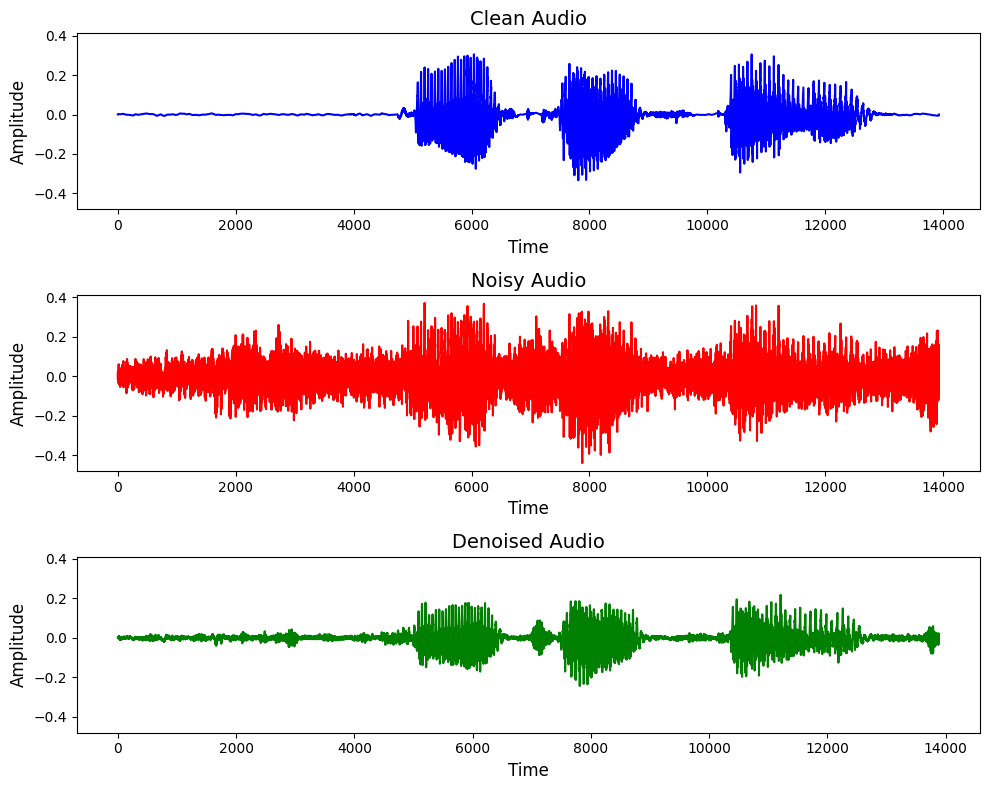

In [89]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(10, 8))

# Plot clean audio
ax1.plot(cleanAudio, color='b')
ax1.set_title("Clean Audio", fontsize=14)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("Amplitude", fontsize=12)

# Plot noisy audio
ax2.plot(noisyAudio, color='r')
ax2.set_title("Noisy Audio", fontsize=14)
ax2.set_xlabel("Time", fontsize=12)
ax2.set_ylabel("Amplitude", fontsize=12)

# Plot denoised audio
ax3.plot(denoisedAudioFullyConvolutional, color='g')
ax3.set_title("Denoised Audio", fontsize=14)
ax3.set_xlabel("Time", fontsize=12)
ax3.set_ylabel("Amplitude", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### inception_resnet_model

In [91]:
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Activation, Add, Concatenate
from tensorflow.keras import Model

def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def inception_res_block(x, filters, kernel_sizes, strides, padding='same'):
    conv1x1 = conv_block(x, filters[0], (1, 1), strides[0], padding)

    conv3x3_reduce = conv_block(x, filters[1], (1, 1), strides[1], padding)
    conv3x3 = conv_block(conv3x3_reduce, filters[2], (3, 3), (1, 1), padding)

    conv5x5_reduce = conv_block(x, filters[3], (1, 1), strides[2], padding)
    conv5x5 = conv_block(conv5x5_reduce, filters[4], (5, 5), (1, 1), padding)

    maxpool = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=strides[3], padding=padding)(x)
    maxpool_conv = conv_block(maxpool, filters[5], (1, 1), (1, 1), padding)

    x = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    x = conv_block(x, filters[6], (1, 1), (1, 1), padding)

    shortcut = x
    x = Add()([x, shortcut])
    return x

def build_inception_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs
    x = tf.keras.layers.ZeroPadding2D(((4, 4), (0, 0)))(x)

    # Initial convolution
    x = Conv2D(filters=18, kernel_size=[9, 8], strides=[1, 1], padding='valid', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(0.0))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # Inception-ResNet blocks
    x = inception_res_block(x, filters=[8, 8, 8, 8, 8, 8, 8], kernel_sizes=[(1, 1), (1, 1), (3, 3), (1, 1), (5, 5), (1, 1)], strides=[1, 1, 1, 1, 1, 1])

    # Spatial Dropout and final convolution
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129, 1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), psnr_metric])
    return model

inception_resnet_model = build_inception_resnet_model(input_shape=(129, 8, 1))
inception_resnet_model.summary()

# Continue with the rest of your training code...


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 129, 8, 1)]          0         []                            
                                                                                                  
 zero_padding2d_3 (ZeroPadd  (None, 137, 8, 1)            0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_49 (Conv2D)          (None, 129, 1, 18)           1296      ['zero_padding2d_3[0][0]']    
                                                                                                  
 activation_28 (Activation)  (None, 129, 1, 18)           0         ['conv2d_49[0][0]']     

In [92]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 129, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 129, 1, 1), dtype=tf.float32, name=None))>

In [93]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 129, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 129, 1, 1), dtype=tf.float32, name=None))>

In [94]:
inception_resnet_model.fit(train_dataset,
                 steps_per_epoch=600,
                 validation_data=test_dataset,
                 epochs=25,
                )

Epoch 1/25
600/600 [==============================] - 48s 71ms/step - loss: 0.6056 - rmse: 0.7543 - psnr_metric: 2.8423 - val_loss: 0.3631 - val_rmse: 0.5743 - val_psnr_metric: 4.8460
Epoch 2/25
600/600 [==============================] - 40s 67ms/step - loss: 0.3607 - rmse: 0.5741 - psnr_metric: 4.8291 - val_loss: 0.2955 - val_rmse: 0.5164 - val_psnr_metric: 5.7566
Epoch 3/25
600/600 [==============================] - 41s 69ms/step - loss: 0.3178 - rmse: 0.5397 - psnr_metric: 5.3598 - val_loss: 0.2582 - val_rmse: 0.4837 - val_psnr_metric: 6.3259
Epoch 4/25
600/600 [==============================] - 44s 73ms/step - loss: 0.2933 - rmse: 0.5207 - psnr_metric: 5.6709 - val_loss: 0.2418 - val_rmse: 0.4709 - val_psnr_metric: 6.5596
Epoch 5/25
600/600 [==============================] - 37s 62ms/step - loss: 0.2759 - rmse: 0.5077 - psnr_metric: 5.8919 - val_loss: 0.2264 - val_rmse: 0.4583 - val_psnr_metric: 6.7933
Epoch 6/25
600/600 [==============================] - 42s 70ms/step - loss: 0.26

In [96]:
inception_resnet_model.save('/content/drive/MyDrive/denoising/inception_resnet_model.h5')

In [97]:
cleanAudio, sr = read_audio('/content/noisy_speech/clean_testset_wav/p232_001.wav', sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.30532587


In [98]:
noiseAudio, sr = read_audio(os.path.join('/content/urbansound8k', 'fold6', '108638-9-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.2976664


In [99]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 1.086894e-06 Max: 9.639375


In [100]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [101]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [102]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 218)


In [103]:
predictors = prepare_input_features(noise_stft_features)

In [104]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (218, 129, 8, 1)


In [105]:
# model = model.loa
resnet_model_pred = inception_resnet_model.predict(predictors)
print(resnet_model_pred.shape)

7/7 [==============================] - 0s 23ms/step
(218, 129, 1, 1)


In [106]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [107]:
denoisedAudioFullyConvolutional = revert_features_to_audio(resnet_model_pred, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.28779224 Max: 0.23513843


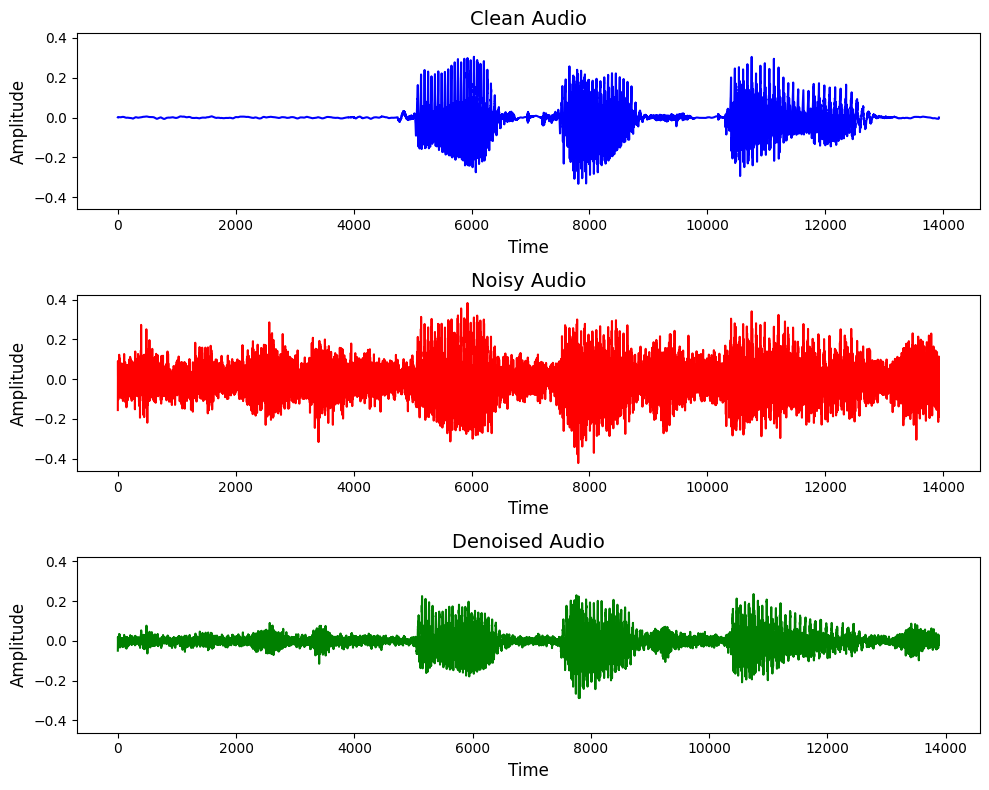

In [108]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(10, 8))

# Plot clean audio
ax1.plot(cleanAudio, color='b')
ax1.set_title("Clean Audio", fontsize=14)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("Amplitude", fontsize=12)

# Plot noisy audio
ax2.plot(noisyAudio, color='r')
ax2.set_title("Noisy Audio", fontsize=14)
ax2.set_xlabel("Time", fontsize=12)
ax2.set_ylabel("Amplitude", fontsize=12)

# Plot denoised audio
ax3.plot(denoisedAudioFullyConvolutional, color='g')
ax3.set_title("Denoised Audio", fontsize=14)
ax3.set_xlabel("Time", fontsize=12)
ax3.set_ylabel("Amplitude", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### CNN + LSTM

In [113]:
from tensorflow.keras.layers import MaxPooling2D, LeakyReLU, Dropout, LSTM, Reshape, Input, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten, Dense

def build_LSTM_model(l2_strength, dropout_rate):
    inputs = Input(shape=[numFeatures, numSegments, 1])
    x = inputs

    x = tf.keras.layers.ZeroPadding2D(((4, 4), (0, 0)))(x)
    x = Conv2D(filters=18, kernel_size=[9, 8], strides=[1, 1], padding='valid', use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(0.0))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Reshape((numFeatures, -1))(x)  # Reshape for LSTM

    x = LSTM(64, return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = LSTM(32, return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = LSTM(16, return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = LSTM(8, return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Add an extra dimension for compatibility with Conv2D
    x = Reshape((numFeatures, numSegments, 1))(x)

    # Adjust Reshape to get the desired output shape
    x = Reshape((numFeatures, 1, -1))(x)

    x = Conv2D(filters=1, kernel_size=[129, 1], strides=(1, 1), padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)

    # x = Reshape((numFeatures, numSegments, 1))(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), psnr_metric])

    return model

# Example usage:
modified_model = build_LSTM_model(l2_strength=0.001, dropout_rate=0.3)


In [114]:
modified_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 129, 8, 1)]       0         
                                                                 
 zero_padding2d_5 (ZeroPadd  (None, 137, 8, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_60 (Conv2D)          (None, 129, 1, 18)        1296      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 129, 1, 18)        0         
                                                                 
 batch_normalization_53 (Ba  (None, 129, 1, 18)        72        
 tchNormalization)                                               
                                                                 
 dropout_17 (Dropout)        (None, 129, 1, 18)        0   

In [115]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode="auto")

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/speech_denoiser.h5',
                                                         monitor='val_loss', save_best_only=True)

In [135]:
modified_model.fit(train_dataset,
         steps_per_epoch=600,
         validation_data=test_dataset,
         epochs=20,
         callbacks=[early_stopping_callback, checkpoint_callback]
        )

Epoch 1/20
600/600 [==============================] - 55s 91ms/step - loss: 0.2172 - rmse: 0.4659 - psnr_metric: 6.6384 - val_loss: 0.1674 - val_rmse: 0.4090 - val_psnr_metric: 7.8178
Epoch 2/20
  1/600 [..............................] - ETA: 40s - loss: 0.2156 - rmse: 0.4643 - psnr_metric: 6.6646

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 45s 76ms/step - loss: 0.2098 - rmse: 0.4580 - psnr_metric: 6.7865 - val_loss: 0.1695 - val_rmse: 0.4116 - val_psnr_metric: 7.7661
Epoch 3/20
600/600 [==============================] - 50s 83ms/step - loss: 0.2048 - rmse: 0.4525 - psnr_metric: 6.8920 - val_loss: 0.1649 - val_rmse: 0.4060 - val_psnr_metric: 7.8829
Epoch 4/20
600/600 [==============================] - 47s 78ms/step - loss: 0.1992 - rmse: 0.4463 - psnr_metric: 7.0111 - val_loss: 0.1573 - val_rmse: 0.3965 - val_psnr_metric: 8.0922
Epoch 5/20
600/600 [==============================] - 47s 79ms/step - loss: 0.1943 - rmse: 0.4407 - psnr_metric: 7.1203 - val_loss: 0.1566 - val_rmse: 0.3956 - val_psnr_metric: 8.1134
Epoch 6/20
600/600 [==============================] - 45s 74ms/step - loss: 0.1919 - rmse: 0.4380 - psnr_metric: 7.1747 - val_loss: 0.1523 - val_rmse: 0.3902 - val_psnr_metric: 8.2395
Epoch 7/20
600/600 [==============================] - 44s 73ms/step - loss: 0.1878 - rmse: 

In [136]:
# Assuming you have a trained model named 'model'
model.save("/content/drive/MyDrive/Projects/denoising/LSTM.h5")

In [137]:
def read_audio(filepath, sample_rate, normalize=True):
    # print(f"Reading: {filepath}").
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr

def add_noise_to_clean_audio(clean_audio, noise_signal):
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [138]:
cleanAudio, sr = read_audio('/content/noisy_speech/clean_testset_wav/p232_001.wav', sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.30532587


In [139]:
noiseAudio, sr = read_audio(os.path.join('/content/urbansound8k', 'fold6', '108638-9-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.2976664


In [140]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 1.086894e-06 Max: 9.639375


In [141]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [142]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [143]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 218)


In [144]:
predictors = prepare_input_features(noise_stft_features)

In [145]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (218, 129, 8, 1)


In [146]:
# model = model.loa
STFTFullyConvolutional = modified_model.predict(predictors)
print(STFTFullyConvolutional.shape)

7/7 [==============================] - 0s 15ms/step
(218, 129, 1, 1)


In [147]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [148]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.20981479 Max: 0.2047001


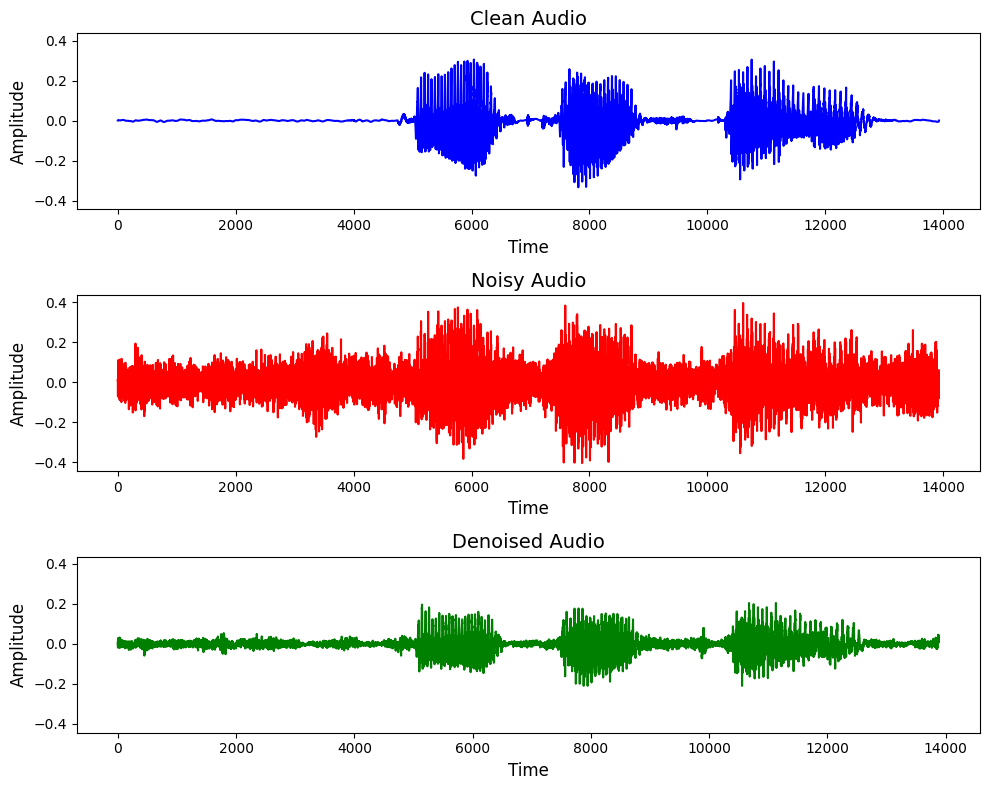

In [149]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(10, 8))

# Plot clean audio
ax1.plot(cleanAudio, color='b')
ax1.set_title("Clean Audio", fontsize=14)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("Amplitude", fontsize=12)

# Plot noisy audio
ax2.plot(noisyAudio, color='r')
ax2.set_title("Noisy Audio", fontsize=14)
ax2.set_xlabel("Time", fontsize=12)
ax2.set_ylabel("Amplitude", fontsize=12)

# Plot denoised audio
ax3.plot(denoisedAudioFullyConvolutional, color='g')
ax3.set_title("Denoised Audio", fontsize=14)
ax3.set_xlabel("Time", fontsize=12)
ax3.set_ylabel("Amplitude", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
